# IEOR 142A: Crime Classification Prediction

By: Amish Gupta, Alex Wong, Lauryn Nakamitsu, and Samantha Tang

## Part 0: Loading libraries + cleaning dataset

In [1]:
!pip install statsmodels==0.14.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 44.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.formula.api as smf
from sklearn.inspection import permutation_importance

In [3]:
# Load in data (after analyzing the dataset, delete any ouputs such as df.inf(), df.head(), et).
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Dummy Encoding Categorical Variables

In [4]:
dummies_sex = pd.get_dummies(train['Victim_Sex'], prefix='Victim_Sex', dummy_na=True)
dummies_sex.drop(columns=['Victim_Sex_nan', 'Victim_Sex_H'], inplace=True)
train = pd.concat([train, dummies_sex], axis=1)
train.drop(columns=['Victim_Sex'], inplace=True)


dummies_descent = pd.get_dummies(train['Victim_Descent'], prefix='Victim_Descent', dummy_na=True)
dummies_descent.drop(columns=['Victim_Descent_nan', 'Victim_Descent_H'], inplace=True)
train = pd.concat([train, dummies_descent], axis=1)
train.drop(columns=['Victim_Descent'], inplace=True)


dummies_status = pd.get_dummies(train['Status'], prefix='Status', dummy_na=True)
dummies_status.drop(columns=['Status_nan'], inplace=True)
train = pd.concat([train, dummies_status], axis=1)
train.drop(columns=['Status'], inplace=True)

train.drop(columns=['Location','Cross_Street','Area_Name','Status_Description','Premise_Description'], inplace=True)

In [5]:
dummies_sex_test = pd.get_dummies(test['Victim_Sex'], prefix='Victim_Sex', dummy_na=True)
dummies_sex_test.drop(columns=['Victim_Sex_nan', 'Victim_Sex_H'], inplace=True)
test = pd.concat([test, dummies_sex], axis=1)
test.drop(columns=['Victim_Sex'], inplace=True)


dummies_descent_test = pd.get_dummies(test['Victim_Descent'], prefix='Victim_Descent', dummy_na=True)
dummies_descent_test.drop(columns=['Victim_Descent_nan', 'Victim_Descent_H'], inplace=True)
test = pd.concat([test, dummies_descent], axis=1)
test.drop(columns=['Victim_Descent'], inplace=True)


dummies_status_test = pd.get_dummies(test['Status'], prefix='Status', dummy_na=True)
dummies_status_test.drop(columns=['Status_nan'], inplace=True)
test = pd.concat([test, dummies_status], axis=1)
test.drop(columns=['Status'], inplace=True)

test.drop(columns=['Location','Cross_Street','Area_Name','Status_Description','Premise_Description'], inplace=True)

### Converting datetime values

In [6]:
# Date Occured
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])
train['month_occurred'] = train['Date_Occurred'].dt.month
train['day_occurred'] = train['Date_Occurred'].dt.day
train['year_occurred'] = train['Date_Occurred'].dt.year

# Date Reported
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'])
train['month_reported'] = train['Date_Reported'].dt.month
train['day_reported'] = train['Date_Reported'].dt.day
train['year_reported'] = train['Date_Reported'].dt.year

train.drop(columns=['Date_Occurred', 'Date_Reported'], inplace=True)

/tmp/ipykernel_36/1109134263.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])
/tmp/ipykernel_36/1109134263.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Date_Reported'] = pd.to_datetime(train['Date_Reported'])


In [7]:
# Date Occured
test['Date_Occurred'] = pd.to_datetime(test['Date_Occurred'])
test['month_occurred'] = test['Date_Occurred'].dt.month
test['day_occurred'] = test['Date_Occurred'].dt.day
test['year_occurred'] = test['Date_Occurred'].dt.year

# Date Reported
test['Date_Reported'] = pd.to_datetime(test['Date_Reported'])
test['month_reported'] = test['Date_Reported'].dt.month
test['day_reported'] = test['Date_Reported'].dt.day
test['year_reported'] = test['Date_Reported'].dt.year

test.drop(columns=['Date_Occurred', 'Date_Reported'], inplace=True)

/tmp/ipykernel_36/2817374067.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Date_Occurred'] = pd.to_datetime(test['Date_Occurred'])
/tmp/ipykernel_36/2817374067.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Date_Reported'] = pd.to_datetime(test['Date_Reported'])


### Dropping text-based columns

In [8]:
train.drop(columns=['Weapon_Description','Modus_Operandi','Weapon_Used_Code'], inplace=True)
test.drop(columns=['Weapon_Description','Modus_Operandi','Weapon_Used_Code'], inplace=True)

## Part 1: Basic modeling

Modeling and hyperparameter tuning with all columns.

### Defining dependent and independent variables

In [9]:
X_train = train.drop(columns=['Crime_Category'])
y_train = train['Crime_Category']
X_test = test.dropna()

In [10]:
train.columns

Index(['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Crime_Category', 'Victim_Sex_F', 'Victim_Sex_M', 'Victim_Sex_X',
       'Victim_Descent_A', 'Victim_Descent_B', 'Victim_Descent_C',
       'Victim_Descent_D', 'Victim_Descent_F', 'Victim_Descent_G',
       'Victim_Descent_I', 'Victim_Descent_J', 'Victim_Descent_K',
       'Victim_Descent_O', 'Victim_Descent_P', 'Victim_Descent_U',
       'Victim_Descent_V', 'Victim_Descent_W', 'Victim_Descent_X',
       'Victim_Descent_Z', 'Status_AA', 'Status_AO', 'Status_IC', 'Status_JA',
       'Status_JO', 'month_occurred', 'day_occurred', 'year_occurred',
       'month_reported', 'day_reported', 'year_reported'],
      dtype='object')

In [11]:
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

In [12]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

### Baseline Model

In [13]:
#BASELINE MODEL
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

most_frequent_class = y_train2.value_counts().idxmax()

y_baseline_pred = np.full_like(y_test2, fill_value=most_frequent_class)

model_baseline = accuracy_score(y_test2, y_baseline_pred)
print(f'Baseline Model Accuracy: {model_baseline:.4f}')

print("\nClassification Report for Baseline Model:")
print(classification_report(y_test2, y_baseline_pred))

print("\nConfusion Matrix for Baseline Model:")
print(confusion_matrix(y_test2, y_baseline_pred))


Baseline Model Accuracy: 0.5768

Classification Report for Baseline Model:
                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        57
  Crimes against Public Order       0.00      0.00      0.00       543
Fraud and White-Collar Crimes       0.00      0.00      0.00       422
                 Other Crimes       0.00      0.00      0.00        55
              Property Crimes       0.58      1.00      0.73      3461
               Violent Crimes       0.00      0.00      0.00      1462

                     accuracy                           0.58      6000
                    macro avg       0.10      0.17      0.12      6000
                 weighted avg       0.33      0.58      0.42      6000


Confusion Matrix for Baseline Model:
[[   0    0    0    0   57    0]
 [   0    0    0    0  543    0]
 [   0    0    0    0  422    0]
 [   0    0    0    0   55    0]
 [   0    0    0    0 3461    0]
 [   0   

### Random Forest

In [14]:
rf_param_grid = {"max_features": [2, 4, 6, 8, 10]}
rf = RandomForestClassifier(random_state=2024)
grid_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring="accuracy")
grid_rf.fit(X_train2, y_train2)
best_rf = grid_rf.best_estimator_
print(f"Best max_features: {grid_rf.best_params_['max_features']}")
rf_predictions = best_rf.predict(X_test2)

model_rf = accuracy_score(y_test2, rf_predictions)
print(f'CV Random Forest Test Accuracy: {model_rf:.4f}')

Best max_features: 10
CV Random Forest Test Accuracy: 0.7400


### Gradient Boosting

In [15]:
# make a gradient boosting model predicting "Category"
gb = GradientBoostingClassifier()
gb.fit(X_train2, y_train2)
y_pred_gb = gb.predict(X_test2)

model_gb = accuracy_score(y_test2, y_pred_gb)
print(f'Gradient Boosting Test Accuracy: {model_gb:.4f}')

print("\nClassification Report for Gradient Boosting:")
print(classification_report(y_test2, y_pred_gb))

print("\nConfusion Matrix for Gradient Boosting:")
print(confusion_matrix(y_test2, y_pred_gb))

Gradient Boosting Test Accuracy: 0.7558

Classification Report for Gradient Boosting:
                               precision    recall  f1-score   support

       Crimes against Persons       0.65      0.72      0.68        57
  Crimes against Public Order       0.44      0.06      0.11       543
Fraud and White-Collar Crimes       0.69      0.66      0.68       422
                 Other Crimes       0.21      0.05      0.09        55
              Property Crimes       0.85      0.91      0.88      3461
               Violent Crimes       0.59      0.71      0.64      1462

                     accuracy                           0.76      6000
                    macro avg       0.57      0.52      0.51      6000
                 weighted avg       0.73      0.76      0.73      6000


Confusion Matrix for Gradient Boosting:
[[  41    0    3    0    0   13]
 [   6   34   41    4  139  319]
 [   1    5  280    0   40   96]
 [   0    3    6    3   13   30]
 [   1   10   32    6 3145  

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)


log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train2, y_train2)

y_pred_log_reg = log_reg.predict(X_test2)

model_lr = accuracy_score(y_test2, y_pred_log_reg)
print(f'Logistic Regression Test Accuracy: {model_lr:.4f}')

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test2, y_pred_log_reg))

print("\nConfusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test2, y_pred_log_reg))


/root/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Logistic Regression Test Accuracy: 0.6263

Classification Report for Logistic Regression:
                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        57
  Crimes against Public Order       0.00      0.00      0.00       543
Fraud and White-Collar Crimes       0.50      0.21      0.29       422
                 Other Crimes       0.00      0.00      0.00        55
              Property Crimes       0.64    

In [17]:
# cart

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)


cart = DecisionTreeClassifier(random_state=42)
cart.fit(X_train2, y_train2)
y_pred_cart = cart.predict(X_test2)

model_cart = accuracy_score(y_test2, y_pred_cart)
print(f'Cart Test Accuracy: {model_cart:.4f}')

print("\nClassification Report for CART:")
print(classification_report(y_test2, y_pred_cart))

Cart Test Accuracy: 0.6585

Classification Report for CART:
                               precision    recall  f1-score   support

       Crimes against Persons       0.49      0.49      0.49        57
  Crimes against Public Order       0.21      0.24      0.22       543
Fraud and White-Collar Crimes       0.55      0.50      0.53       422
                 Other Crimes       0.11      0.11      0.11        55
              Property Crimes       0.82      0.82      0.82      3461
               Violent Crimes       0.52      0.51      0.52      1462

                     accuracy                           0.66      6000
                    macro avg       0.45      0.45      0.45      6000
                 weighted avg       0.66      0.66      0.66      6000



In [18]:
# lda

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)


lda = LinearDiscriminantAnalysis()
lda.fit(X_train2, y_train2)
y_pred_lda = lda.predict(X_test2)

model_lda = accuracy_score(y_test2, y_pred_lda)
print(f'LDA Test Accuracy: {model_lda:.4f}')

LDA Test Accuracy: 0.6942


### ROC Curve

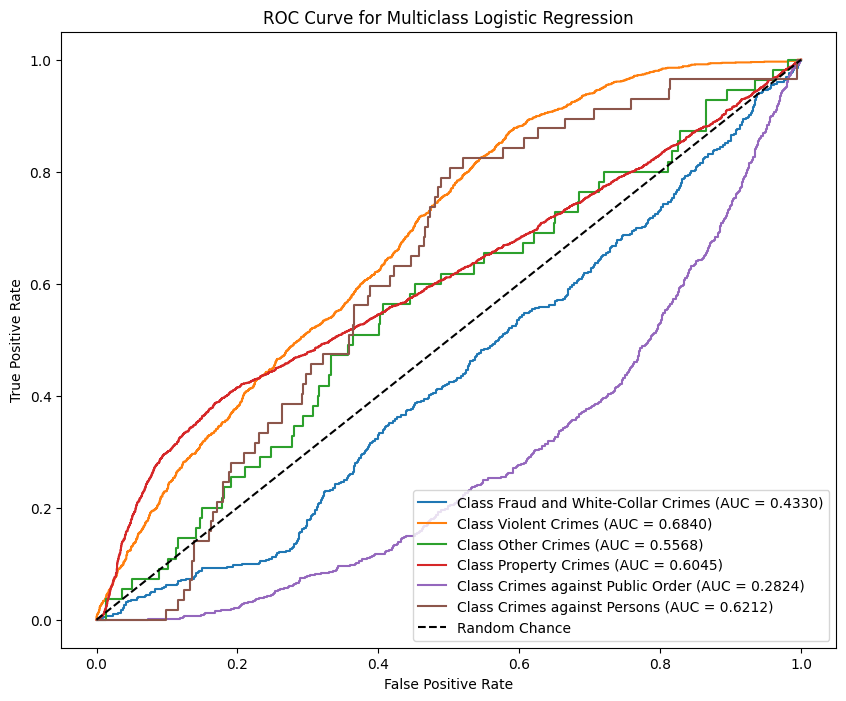

In [19]:
#ROC Curve for Multiclass Logistic Regression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

classes = list(set(y_test2))
y_test_binarized = label_binarize(y_test2, classes=classes)
y_prob_log_reg = log_reg.predict_proba(X_test2)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_log_reg[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Logistic Regression')
plt.legend()
plt.show()


In [20]:
# logreg = smf.logit(formula = 'Crime_Category ~ Latitude + Longitude + Time_Occurred + Area_ID + Reporting_District_no + Part 1-2 + Victim_Age + Premise_Code + Crime_Category + Victim_Sex_F + Victim_Sex_M + Victim_Sex_X  + Victim_Descent_A + Victim_Descent_B + Victim_Descent_C + Victim_Descent_D + Victim_Descent_F + Victim_Descent_G + Victim_Descent_I + Victim_Descent_J + Victim_Descent_K + Victim_Descent_O + Victim_Descent_P + Victim_Descent_U + Victim_Descent_V + Victim_Descent_W + Victim_Descent_X + Victim_Descent_Z + Status_AA + Status_AO + Status_IC + Status_JA + Status_JO + month_occurred + day_occurred + year_occurred + month_reported + day_reported + year_reported',
#                        data = train).fit()
# print(logreg.summary())

In [21]:
train.columns

Index(['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Crime_Category', 'Victim_Sex_F', 'Victim_Sex_M', 'Victim_Sex_X',
       'Victim_Descent_A', 'Victim_Descent_B', 'Victim_Descent_C',
       'Victim_Descent_D', 'Victim_Descent_F', 'Victim_Descent_G',
       'Victim_Descent_I', 'Victim_Descent_J', 'Victim_Descent_K',
       'Victim_Descent_O', 'Victim_Descent_P', 'Victim_Descent_U',
       'Victim_Descent_V', 'Victim_Descent_W', 'Victim_Descent_X',
       'Victim_Descent_Z', 'Status_AA', 'Status_AO', 'Status_IC', 'Status_JA',
       'Status_JO', 'month_occurred', 'day_occurred', 'year_occurred',
       'month_reported', 'day_reported', 'year_reported'],
      dtype='object')

## Part II: Feature selection + basic modeling

### Feature Selection

                  Feature  Mean Importance
5                Part 1-2         0.155850
7            Premise_Code         0.050833
6              Victim_Age         0.041400
29              Status_IC         0.040983
9            Victim_Sex_M         0.014050
8            Victim_Sex_F         0.008283
37          year_reported         0.006633
2           Time_Occurred         0.004233
27              Status_AA         0.003200
0                Latitude         0.001950
25       Victim_Descent_X         0.001917
20       Victim_Descent_O         0.001783
1               Longitude         0.000983
12       Victim_Descent_B         0.000550
11       Victim_Descent_A         0.000133
10           Victim_Sex_X         0.000083
33           day_occurred         0.000017
31              Status_JO         0.000017
34          year_occurred         0.000000
30              Status_JA         0.000000
13       Victim_Descent_C         0.000000
14       Victim_Descent_D         0.000000
23       Vi

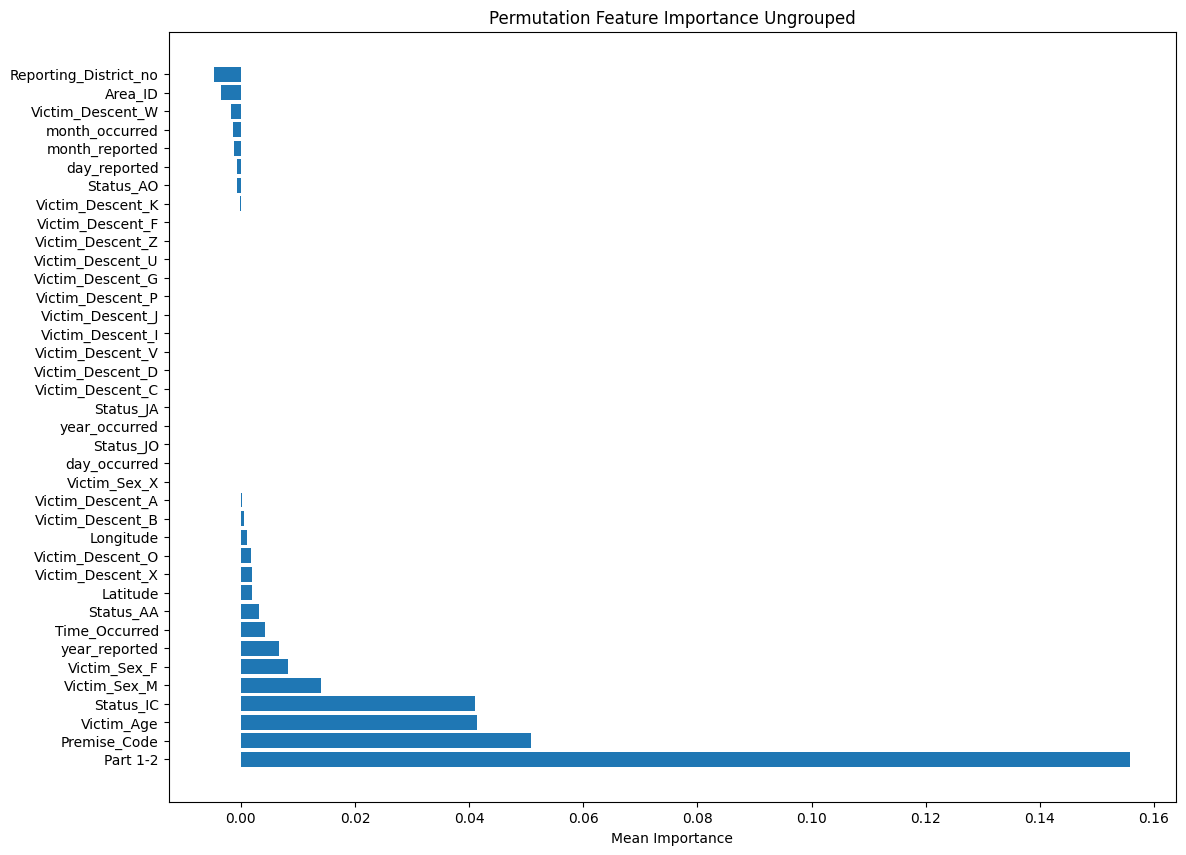

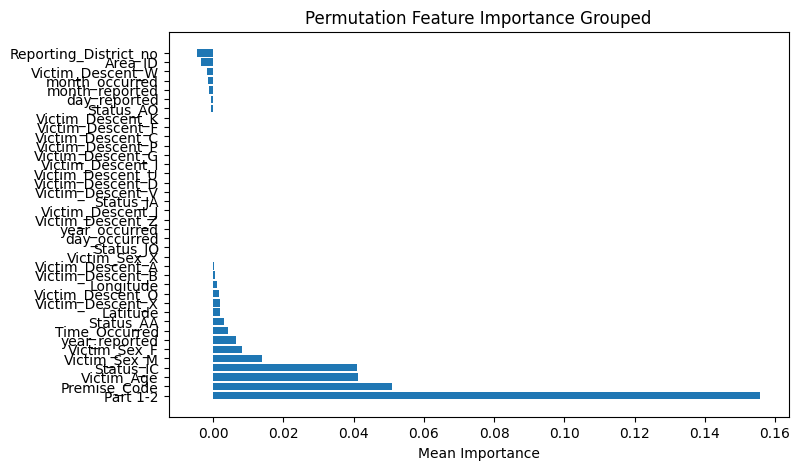

In [22]:
perms = permutation_importance(best_rf, X_test2, y_test2, n_repeats=10, random_state=88)

perm_df = pd.DataFrame({
    'Feature': X_train2.columns,
    'Mean Importance': perms.importances_mean
}).sort_values(by='Mean Importance', ascending=False)

print(perm_df)

plt.figure(figsize=(13, 10))
plt.barh(perm_df['Feature'], perm_df['Mean Importance'])
plt.xlabel('Mean Importance')
plt.title('Permutation Feature Importance Ungrouped')
plt.show()

perm_df['Feature'] = perm_df['Feature'].str.replace(r'_(TRUE|FALSE)', '', regex=True)
combined = perm_df.groupby('Feature').agg({'Mean Importance': 'sum'}).reset_index()
combined = combined.sort_values(by='Mean Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(combined['Feature'], combined['Mean Importance'])
plt.xlabel('Mean Importance')
plt.title('Permutation Feature Importance Grouped')
plt.show()

In [23]:
train2 = train.drop(columns=['Victim_Descent_A', 'Victim_Descent_B', 'Victim_Descent_C',
       'Victim_Descent_D', 'Victim_Descent_F', 'Victim_Descent_G',
       'Victim_Descent_I', 'Victim_Descent_J', 'Victim_Descent_K',
       'Victim_Descent_O', 'Victim_Descent_P', 'Victim_Descent_U',
       'Victim_Descent_V', 'Victim_Descent_W', 'Victim_Descent_X',
       'Victim_Descent_Z','Reporting_District_no','Area_ID',
       'day_occurred', 'month_occurred','year_occurred','day_reported',
       'month_reported'])

test2 = test.drop(columns=['Victim_Descent_A', 'Victim_Descent_B', 'Victim_Descent_C',
       'Victim_Descent_D', 'Victim_Descent_F', 'Victim_Descent_G',
       'Victim_Descent_I', 'Victim_Descent_J', 'Victim_Descent_K',
       'Victim_Descent_O', 'Victim_Descent_P', 'Victim_Descent_U',
       'Victim_Descent_V', 'Victim_Descent_W', 'Victim_Descent_X',
       'Victim_Descent_Z','Reporting_District_no','Area_ID',
       'day_occurred', 'month_occurred','year_occurred','day_reported',
       'month_reported'])

In [24]:
X_train_dropped = train2.drop(columns=['Crime_Category'])
y_train_dropped = train2['Crime_Category']
X_test_dropped = test2.dropna()

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_train_dropped, y_train_dropped, test_size=0.3, random_state=42)

### Baseline model with selected features

In [25]:
# baseline model
# NEW BASELINE MODEL WITH SELECTED FEATURES

most_frequent_class = y_train3.value_counts().idxmax()

y_baseline_pred = np.full_like(y_test3, fill_value=most_frequent_class)

model_baseline_sf = accuracy_score(y_test3, y_baseline_pred)
print(f'Baseline Test Accuracy: {model_baseline_sf:.4f}')

Baseline Test Accuracy: 0.5768


### Logistic regression with selected features

In [26]:
#NEW LOGISTIC REGRESSION WITH SELECTED FEATURES

scaler = StandardScaler()
X_train3_scaled = scaler.fit_transform(X_train3)
X_test3_scaled = scaler.transform(X_test3)


log_reg = LogisticRegression(max_iter=2000, random_state=42)

log_reg.fit(X_train3, y_train3)

y_pred_log_reg = log_reg.predict(X_test3)

model_lr_sf = accuracy_score(y_test3, y_pred_log_reg)
print(f'Logistic Regression Test Accuracy: {model_lr_sf:.4f}')


Logistic Regression Test Accuracy: 0.6445
/root/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random forest with selected features

In [27]:
#NEW RANDOM FOREST WITH SELECTED FEATURES
rf_param_grid = {"max_features": [2, 4, 6, 8, 10]}
rf = RandomForestClassifier(random_state=2024)
grid_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring="accuracy")
grid_rf.fit(X_train3, y_train3)
best_rf = grid_rf.best_estimator_
print(f"Best max_features: {grid_rf.best_params_['max_features']}")
rf_predictions = best_rf.predict(X_test3)

model_rf_sf = accuracy_score(y_test3, rf_predictions)
print(f'CV Random Forest Test Accuracy: {model_rf_sf:.4f}')

Best max_features: 6
CV Random Forest Test Accuracy: 0.7480


### Gradient boosting with selected features

In [28]:
# make a gradient boosting model predicting "Category"
gb = GradientBoostingClassifier()
gb.fit(X_train3, y_train3)
y_pred_gb = gb.predict(X_test3)

model_gb_sf = accuracy_score(y_test3, y_pred_gb)
print(f'Gradient Boosting Test Accuracy: {model_gb_sf:.4f}')

Gradient Boosting Test Accuracy: 0.7487


### CART with feature selection

In [30]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train3)
y_test_encoded = label_encoder.transform(y_test3)


params = {'ccp_alpha': np.linspace(0, 0.10, 201)}
dtc = DecisionTreeClassifier(random_state=2024)
cross_val = KFold(n_splits=5, random_state=1, shuffle=True)
grid = GridSearchCV(dtc, param_grid=params, scoring='r2', cv=cross_val, verbose=0)
grid.fit(X_train3, y_train_encoded)

best_cart = grid.best_estimator_
y_pred_cart = best_cart.predict(X_test3)
ccp_alpha = grid.best_params_

#given
model_cart_sf = accuracy_score(y_test_encoded, y_pred_cart)
model_cart_sf_best_ccp_alpha = ccp_alpha['ccp_alpha']
print(f'CV CART Test Accuracy: {model_cart_sf:.4f}')
print(f'Best ccp_alpha: {model_cart_sf_best_ccp_alpha:.4f}')

CV CART Test Accuracy: 0.6725
Best ccp_alpha: 0.0095


### LDA with feature selection

In [31]:
#delete
lda = LinearDiscriminantAnalysis()
lda.fit(X_train2, y_train2)
lda_predictions = lda.predict(X_test2)

# given
model_lda_sf = accuracy_score(y_test2, lda_predictions)
print(f'LDA Test Accuracy: {model_lda_sf:.4f}')

LDA Test Accuracy: 0.6942


In [32]:
# use
lda = LinearDiscriminantAnalysis()
lda.fit(X_train3, y_train3)
lda_predictions = lda.predict(X_test3)

model_lda_sf = accuracy_score(y_test3, lda_predictions)
print(f'LDA Test Accuracy: {model_lda_sf:.4f}')

LDA Test Accuracy: 0.6760


RF and LogReg accuracy went up, GB accuracy went down

## Part III: Sentiment analysis for column "Weapon_Description"

Using sentiment analysis NLP to predict Crime_Category.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# Load in data
weapon = pd.read_csv("train.csv")
weapon = weapon[['Crime_Category', 'Weapon_Description']]
weapon = weapon.dropna()

# Reset index to align correctly after transformation
weapon = weapon.reset_index(drop=True)

# Vectorize the 'Weapon_Description' column
vectorizer = CountVectorizer()
weapon_vector = vectorizer.fit_transform(weapon['Weapon_Description'])
weapon_vector = pd.DataFrame(weapon_vector.toarray(), columns=vectorizer.get_feature_names_out())

# Add 'Crime_Category' to the vectorized DataFrame
weapon_vector['Crime_Category'] = weapon['Crime_Category'].reset_index(drop=True)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
weapon_vector = weapon_vector[[column for column in weapon_vector.columns if column not in stop]]

weapon_vector
# using nlp to see how 57 different instances of weapon_description map to the 6 types of crime categories

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,6inches,93,air,ak47,arm,arts,assault,automatic,axe,bat,...,tire,toy,type,unknown,uzi,vehicle,verbal,weapon,weapons,Crime_Category
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Property Crimes
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Property Crimes
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Violent Crimes
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Violent Crimes
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Crimes against Public Order
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7330,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Violent Crimes
7331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,Crimes against Persons
7332,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Violent Crimes
7333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,Property Crimes


### EDA Example

The word "threat" is heavily prevalent in the category "Crimes against Public Order" compared to other categories indicating significant information about category form word count frequency in "Weapon_Description"

Text(0, 0.5, 'Frequency')

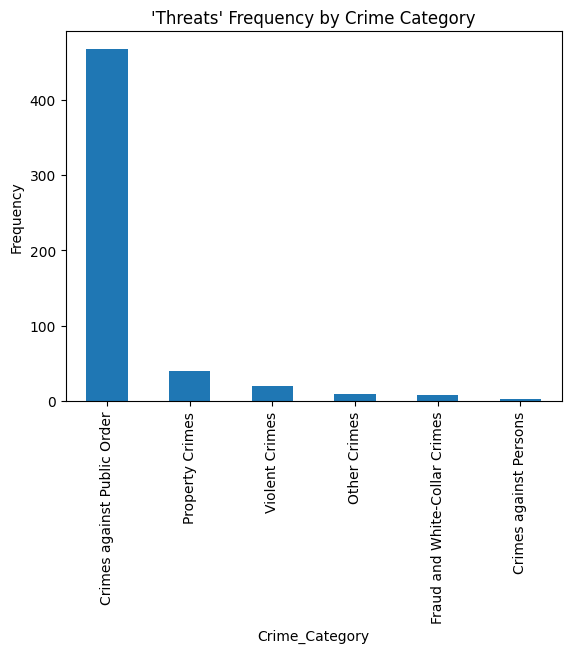

In [34]:
# find unique values of Crime_Category
threat = weapon_vector[weapon_vector['threat']==1]

# count how many times each category appears
threat['Crime_Category'].value_counts()

# make bar graph
threat['Crime_Category'].value_counts().plot.bar()
plt.title("'Threats' Frequency by Crime Category")
plt.ylabel('Frequency')

The bar graph above shows how the mention of the word "threats" in the Weapon_Description, can most likely signify the Crime_category of "Crimes against Public Order" with XXX instances.

### Finding the most important words

In our analysis, we will remove all words that appear in fewer than 1% of weapon descriptions in our X_train (n=0.01x5095=50.95 --> 50). This limits us to the 93 possible non-stop words in the dataset (93/99 = X%). This limits us to just XX% of the text from our Weapon Description dataset (28/99 = XX%). (99 (with stop words) --> 93 (with no stop words)-->28 (applying Zipf’s law)

In [35]:
# create new table from weapon_vector with the column name and count of each
nlp_frequency_table = weapon_vector.drop('Crime_Category', axis=1).sum().sort_values(ascending=False).reset_index()
# rename column 0 with "word"
nlp_frequency_table = nlp_frequency_table.rename(columns={'index': 'word', 0: 'count'})
# add column that denotes the rank of each column including ties, tied for first should all be 1
nlp_frequency_table['rank'] = nlp_frequency_table['count'].rank(ascending=False)
# add column with the Ratio with the Largest Frequency in decimal form
nlp_frequency_table['ratio'] = nlp_frequency_table['count'] / nlp_frequency_table['count'].max()
# remove words with count less than 10
nlp_frequency_table = nlp_frequency_table[nlp_frequency_table['count'] > 73]
nlp_frequency_table

,word,count,rank,ratio
0,strong,3990,4.0,1.000000
1,bodily,3990,4.0,1.000000
2,fist,3990,4.0,1.000000
3,feet,3990,4.0,1.000000
4,hands,3990,4.0,1.000000
5,force,3990,4.0,1.000000
6,arm,3990,4.0,1.000000
7,weapon,1579,8.0,0.395739
8,unknown,944,9.0,0.236591
9,threat,547,10.0,0.137093


Text(0, 0.5, 'Ratio of Frequency')

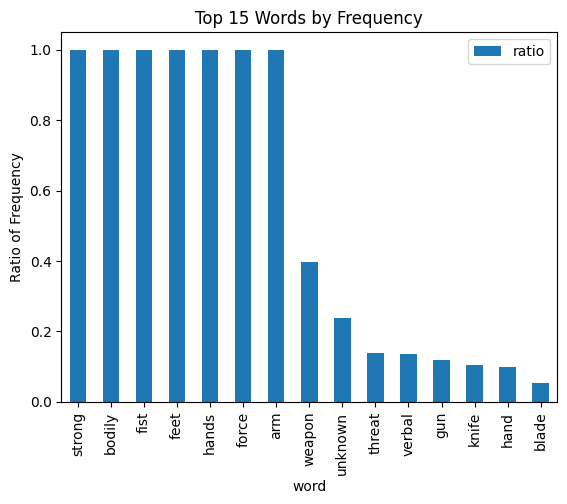

In [36]:
# bar graph of word ratio top 15
nlp_frequency_table.head(15).plot.bar(x='word', y='ratio')
plt.title('Top 15 Words by Frequency')
plt.ylabel('Ratio of Frequency')

### Baseline Model with Sentiment Analysis

In [37]:
# weapon_vector with columns that appear in nlp_frequency_table['word']
weapon_cleaned = weapon_vector[nlp_frequency_table['word']]
weapon_cleaned['Crime_Category'] = weapon_vector['Crime_Category']

# train test split
X_train, X_test, y_train, y_test = train_test_split(weapon_cleaned.drop('Crime_Category', axis=1), weapon_cleaned['Crime_Category'], test_size=0.3, random_state=42)

most_frequent_class = y_train.value_counts().idxmax()

y_baseline_pred = np.full_like(y_test, fill_value=most_frequent_class)

model_baseline_nlp = accuracy_score(y_test, y_baseline_pred)
print(f'Baseline Test Accuracy: {model_baseline_nlp:.4f}')

Baseline Test Accuracy: 0.6402
/tmp/ipykernel_37/2307451346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weapon_cleaned['Crime_Category'] = weapon_vector['Crime_Category']


### Logistic Regression with Sentiment Analysis

In [38]:
#logistic regression using nlp
lg_nlp = LogisticRegression()
lg_nlp.fit(X_train, y_train)

#predict
y_pred_nlp = lg_nlp.predict(X_test)

#accuracy
model_lr_nlp = accuracy_score(y_test, y_pred_nlp)
print(f'Logistic Regression Test Accuracy: {model_lr_nlp:.4f}')

/root/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Logistic Regression Test Accuracy: 0.7079


### Random Forest with Sentiment Analysis

In [39]:
# random forest using nlp
rf_nlp = RandomForestClassifier()
rf_nlp.fit(X_train, y_train)
y_pred_rf_nlp = rf_nlp.predict(X_test)
model_rf_nlp = accuracy_score(y_test, y_pred_rf_nlp)
print(f'Random Forest Test Accuracy: {model_rf_nlp:.4f}')

Random Forest Test Accuracy: 0.7056


### Gradient Boosting with Sentiment Analysis

In [40]:
# gradient boosting using nlp
gb_nlp = GradientBoostingClassifier()
gb_nlp.fit(X_train, y_train)
y_pred_gb_nlp = gb_nlp.predict(X_test)
model_gb_nlp = accuracy_score(y_test, y_pred_gb_nlp)
print(f'Gradient Boosting Test Accuracy: {model_gb_nlp:.4f}')

Gradient Boosting Test Accuracy: 0.7079


### CART with Sentiment Analysis

In [41]:
# cart using nlp
cart_nlp = DecisionTreeClassifier()
cart_nlp.fit(X_train, y_train)
y_pred_cart_nlp = cart_nlp.predict(X_test)
model_cart_nlp = accuracy_score(y_test, y_pred_cart_nlp)
print(f'CART Test Accuracy: {model_cart_nlp:.4f}')

CART Test Accuracy: 0.7056


### LDA with Sentiment Analysis

In [42]:
# lda using nlp
lda_nlp = LinearDiscriminantAnalysis()
lda_nlp.fit(X_train, y_train)
y_pred_lda_nlp = lda_nlp.predict(X_test)
model_lda_nlp = accuracy_score(y_test, y_pred_lda_nlp)
print(f'LDA Test Accuracy: {model_lda_nlp:.4f}')

LDA Test Accuracy: 0.6965


## Part IV: Combining Models with Feature Selection + Sentiment Analysis

This section synthesizes our feature selection and hyperparameter tuning with our sentiment analysis from Part II.

### Reloading Part II

In [43]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

dummies_sex = pd.get_dummies(train['Victim_Sex'], prefix='Victim_Sex', dummy_na=True)
dummies_sex.drop(columns=['Victim_Sex_nan', 'Victim_Sex_H'], inplace=True)
train = pd.concat([train, dummies_sex], axis=1)
train.drop(columns=['Victim_Sex'], inplace=True)


dummies_descent = pd.get_dummies(train['Victim_Descent'], prefix='Victim_Descent', dummy_na=True)
dummies_descent.drop(columns=['Victim_Descent_nan', 'Victim_Descent_H'], inplace=True)
train = pd.concat([train, dummies_descent], axis=1)
train.drop(columns=['Victim_Descent'], inplace=True)


dummies_status = pd.get_dummies(train['Status'], prefix='Status', dummy_na=True)
dummies_status.drop(columns=['Status_nan'], inplace=True)
train = pd.concat([train, dummies_status], axis=1)
train.drop(columns=['Status'], inplace=True)

train.drop(columns=['Location','Cross_Street','Area_Name','Status_Description','Premise_Description'], inplace=True)

dummies_sex_test = pd.get_dummies(test['Victim_Sex'], prefix='Victim_Sex', dummy_na=True)
dummies_sex_test.drop(columns=['Victim_Sex_nan', 'Victim_Sex_H'], inplace=True)
test = pd.concat([test, dummies_sex], axis=1)
test.drop(columns=['Victim_Sex'], inplace=True)


dummies_descent_test = pd.get_dummies(test['Victim_Descent'], prefix='Victim_Descent', dummy_na=True)
dummies_descent_test.drop(columns=['Victim_Descent_nan', 'Victim_Descent_H'], inplace=True)
test = pd.concat([test, dummies_descent], axis=1)
test.drop(columns=['Victim_Descent'], inplace=True)


dummies_status_test = pd.get_dummies(test['Status'], prefix='Status', dummy_na=True)
dummies_status_test.drop(columns=['Status_nan'], inplace=True)
test = pd.concat([test, dummies_status], axis=1)
test.drop(columns=['Status'], inplace=True)

test.drop(columns=['Location','Cross_Street','Area_Name','Status_Description','Premise_Description'], inplace=True)

train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])

train['month_occurred'] = train['Date_Occurred'].dt.month
train['day_occurred'] = train['Date_Occurred'].dt.day
train['year_occurred'] = train['Date_Occurred'].dt.year
# train['time_occurred'] = train['Date_Occurred'].dt.time

# Date Reported
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'])

train['month_reported'] = train['Date_Reported'].dt.month
train['day_reported'] = train['Date_Reported'].dt.day
train['year_reported'] = train['Date_Reported'].dt.year
# train['time_reported'] = train['Date_Reported'].dt.time

train.drop(columns=['Date_Occurred', 'Date_Reported'], inplace=True)

# Date Occured
test['Date_Occurred'] = pd.to_datetime(test['Date_Occurred'])

test['month_occurred'] = test['Date_Occurred'].dt.month
test['day_occurred'] = test['Date_Occurred'].dt.day
test['year_occurred'] = test['Date_Occurred'].dt.year
# test['time_occurred'] = test['Date_Occurred'].dt.time

# Date Reported
test['Date_Reported'] = pd.to_datetime(test['Date_Reported'])

test['month_reported'] = test['Date_Reported'].dt.month
test['day_reported'] = test['Date_Reported'].dt.day
test['year_reported'] = test['Date_Reported'].dt.year
# test['time_reported'] = test['Date_Reported'].dt.time

test.drop(columns=['Date_Occurred', 'Date_Reported'], inplace=True)

train.drop(columns=['Modus_Operandi','Weapon_Used_Code'], inplace=True)
test.drop(columns=['Modus_Operandi','Weapon_Used_Code'], inplace=True)


# get rid of rows where Weapon_Description is null
train = train[train['Weapon_Description'].notna()].drop(columns=['Victim_Descent_A', 'Victim_Descent_B', 'Victim_Descent_C',
       'Victim_Descent_D', 'Victim_Descent_F', 'Victim_Descent_G',
       'Victim_Descent_I', 'Victim_Descent_J', 'Victim_Descent_K',
       'Victim_Descent_O', 'Victim_Descent_P', 'Victim_Descent_U',
       'Victim_Descent_V', 'Victim_Descent_W', 'Victim_Descent_X',
       'Victim_Descent_Z','Reporting_District_no','Area_ID',
       'day_occurred', 'month_occurred','year_occurred','day_reported',
       'month_reported'])

test = test[test['Weapon_Description'].notna()].drop(columns=['Victim_Descent_A', 'Victim_Descent_B', 'Victim_Descent_C',
       'Victim_Descent_D', 'Victim_Descent_F', 'Victim_Descent_G',
       'Victim_Descent_I', 'Victim_Descent_J', 'Victim_Descent_K',
       'Victim_Descent_O', 'Victim_Descent_P', 'Victim_Descent_U',
       'Victim_Descent_V', 'Victim_Descent_W', 'Victim_Descent_X',
       'Victim_Descent_Z','Reporting_District_no','Area_ID',
       'day_occurred', 'month_occurred','year_occurred','day_reported',
       'month_reported'])

train

/tmp/ipykernel_37/2582205702.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])
/tmp/ipykernel_37/2582205702.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Date_Reported'] = pd.to_datetime(train['Date_Reported'])
/tmp/ipykernel_37/2582205702.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Date_Occurred'] = pd.to_datetime(test['Date_Occurred'])
/tmp/ipykernel_37/2582205702.py:68: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

,Latitude,Longitude,Time_Occurred,Part 1-2,Victim_Age,Premise_Code,Weapon_Description,Crime_Category,Victim_Sex_F,Victim_Sex_M,Victim_Sex_X,Status_AA,Status_AO,Status_IC,Status_JA,Status_JO,year_reported
1,34.0028,-118.2391,1345.0,1.0,41.0,216.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Property Crimes,False,True,False,False,False,True,False,False,2020
4,33.9787,-118.2918,1130.0,1.0,0.0,401.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Property Crimes,False,False,True,False,False,True,False,False,2020
5,34.1127,-118.1942,256.0,2.0,50.0,502.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Violent Crimes,False,True,False,False,True,False,False,False,2020
11,33.9875,-118.2860,1430.0,1.0,22.0,121.0,VERBAL THREAT,Violent Crimes,False,True,False,False,False,True,False,False,2020
13,34.0944,-118.3277,215.0,1.0,50.0,102.0,OTHER KNIFE,Crimes against Public Order,False,True,False,False,False,True,False,False,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19982,34.2179,-118.5285,2200.0,2.0,46.0,501.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Violent Crimes,True,False,False,False,False,False,False,True,2020
19983,33.9909,-118.2980,1400.0,2.0,0.0,502.0,UNKNOWN WEAPON/OTHER WEAPON,Crimes against Persons,False,True,False,False,True,False,False,False,2020
19984,34.0980,-118.3197,1845.0,2.0,0.0,502.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Violent Crimes,False,False,True,False,False,True,False,False,2020
19988,33.9914,-118.4132,342.0,1.0,28.0,101.0,UNKNOWN WEAPON/OTHER WEAPON,Property Crimes,True,False,False,False,False,True,False,False,2020


### Concatenating tables

In [44]:
# Reset index to align correctly after transformation
train = train.reset_index(drop=True)

# Vectorize the 'Weapon_Description' column
vectorizer = CountVectorizer()
train_vector = vectorizer.fit_transform(train['Weapon_Description'])
train_vector = pd.DataFrame(train_vector.toarray(), columns=vectorizer.get_feature_names_out())

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_vector = train_vector[[column for column in train_vector.columns if column not in stop]]

# concatenate the vectorized columns with the original dataframe
train = pd.concat([train, train_vector], axis=1)
train.drop(columns=['Weapon_Description'], inplace=True)

# apply to the same vectorizer to the test data
test_vector = vectorizer.transform(test['Weapon_Description'])
test_vector = pd.DataFrame(test_vector.toarray(), columns=vectorizer.get_feature_names_out())
test_vector = test_vector[[column for column in test_vector.columns if column not in stop]]
test = pd.concat([test, test_vector], axis=1)
test.drop(columns=['Weapon_Description'], inplace=True)

X_train_nlp = train.drop(columns=['Crime_Category'])
y_train_nlp = train['Crime_Category']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_train_nlp, y_train_nlp, test_size=0.3, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Baseline

In [45]:
final_frequent_class = y_train4.value_counts().idxmax()

y_baseline_pred = np.full_like(y_test4, fill_value=most_frequent_class)

model_baseline_final = accuracy_score(y_test4, y_baseline_pred)
print(f'Baseline Test Accuracy: {model_baseline_final:.4f}')

Baseline Test Accuracy: 0.6402


### Logistic Regression with Feature Selection + Sentiment Analysis

In [46]:
# logistic regression

lr = LogisticRegression()
lr.fit(X_train4, y_train4)
y_pred_lr = lr.predict(X_test4)

model_lr_final = accuracy_score(y_test4, y_pred_lr)
print(f'Logistic Regression Test Accuracy: {model_lr_final:.4f}')

Logistic Regression Test Accuracy: 0.6388
/root/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest with Feature Selection + Sentiment Analysis

In [47]:
# Random Forest with selected features, tuned hyperparamter, and NLP
rf_param_grid = {"max_features": [2, 4, 6, 8, 10]}
rf = RandomForestClassifier(random_state=2024)
grid_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring="accuracy")
grid_rf.fit(X_train4, y_train4)
best_rf = grid_rf.best_estimator_
print(f"Best max_features: {grid_rf.best_params_['max_features']}")
rf_predictions = best_rf.predict(X_test4)


#given
model_rf_final = accuracy_score(y_test4, rf_predictions)
print(f'CV Random Forest Test Accuracy: {model_rf_final:.4f}')

Best max_features: 4
CV Random Forest Test Accuracy: 0.7933


### Gradient Boosting with Feature Selection + Sentiment Analysis

In [48]:
# Gradient Boosting with selected features, tuned hyperparamter, and NLP
gb = GradientBoostingClassifier()
gb.fit(X_train4, y_train4)
y_pred_gb = gb.predict(X_test4)

model_gb_final = accuracy_score(y_test4, y_pred_gb)
print(f'Gradient Boosting Test Accuracy: {model_gb_final:.4f}')

Gradient Boosting Test Accuracy: 0.8087


### CART with Feature Selection + Sentiment Analysis

In [49]:
# CART decision tree with selected features and NLP
cart = DecisionTreeClassifier()
cart.fit(X_train4, y_train4)
y_pred_cart = cart.predict(X_test4)

model_cart_final = accuracy_score(y_test4, y_pred_cart)
print(f'Cart Test Accuracy: {model_cart_final:.4f}')

Cart Test Accuracy: 0.7460


### LDA with Feature Selection + Sentiment Analysis

In [50]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train4, y_train4)
lda_predictions = lda.predict(X_test4)
model_lda_final = accuracy_score(y_test4, lda_predictions)
print(f'LDA Test Accuracy: {model_lda_final:.4f}')

LDA Test Accuracy: 0.7633


### Results Table

In [51]:
# create a table showing accuracy of models
final_accuracy = pd.DataFrame()

final_accuracy['Model'] = ['Baseline', 'Logistic Regression', 'Random Forest', 'Gradient Boosting', 'CART', 'LDA']
final_accuracy['Basic Modeling'] = [model_baseline, model_lr, model_rf, model_gb, model_cart, model_lda]
final_accuracy['Feature Selection'] = [model_baseline_sf, model_lr_sf, model_rf_sf, model_gb_sf, model_cart_sf, model_lda_sf]
final_accuracy['Sentiment Analysis'] = [model_baseline_nlp, model_lr_nlp, model_rf_nlp, model_gb_nlp, model_cart_nlp, model_lda_nlp]
final_accuracy['Feature Selection + Sentiment Analysis'] = [model_baseline_final, model_lr_final, model_rf_final, model_gb_final, model_cart_final, model_lda_final]
final_accuracy

,Model,Basic Modeling,Feature Selection,Sentiment Analysis,Feature Selection + Sentiment Analysis
0,Baseline,0.576833,0.576833,0.640164,0.640164
1,Logistic Regression,0.626333,0.644500,0.707860,0.638801
2,Random Forest,0.740000,0.748000,0.705588,0.793276
3,Gradient Boosting,0.755833,0.748667,0.707860,0.808723
4,CART,0.658500,0.672500,0.705588,0.746025
5,LDA,0.694167,0.676000,0.696502,0.763289


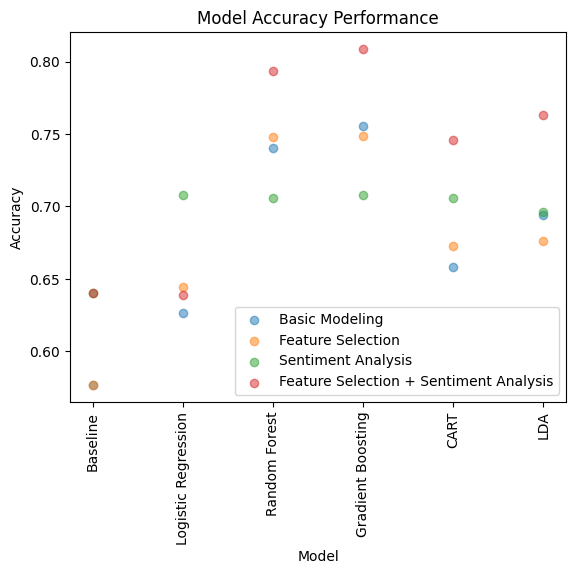

In [52]:
# create a scatter plot where basic modeling = 0, feature slection = 1, sentiment analysis = 2, feature selection + sentiment analysis = 3, points on x axis are models, y axis is accuracy

#lower opacity of dots
plt.scatter(final_accuracy['Model'], final_accuracy['Basic Modeling'], alpha=0.5, label='Basic Modeling')
plt.scatter(final_accuracy['Model'], final_accuracy['Feature Selection'], alpha=0.5, label='Feature Selection')
plt.scatter(final_accuracy['Model'], final_accuracy['Sentiment Analysis'], alpha=0.5, label='Sentiment Analysis')
plt.scatter(final_accuracy['Model'], final_accuracy['Feature Selection + Sentiment Analysis'], alpha=0.5, label='Feature Selection + Sentiment Analysis')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Performance')
plt.show()


### 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f98e5b54-c719-4c06-bf4d-ad2e7ac1dec6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>